In [1]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from model import analyse
import numpy as np

plt.style.use(style="ggplot")

# font size in the paper is 9
plt.rcParams.update({"font.size": 9})

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.0056
SINGLE_COLUMN_FIG_WIDTH = 3.337

# Experiment 3R

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment3R/experiment3R_output"
file_pattern = "experiment3R_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

Let's check that we have all the runs:

In [3]:
len(results)

1536

In [4]:
ids = tuple(r["run_id"] for r in results)
for i in range(1536):
    if i not in ids:
        print(i)

These are the pieces of data we have for each run:

In [5]:
list(results[0].keys())

['run_id',
 'duration',
 'reasoning_level',
 'action_dist_0',
 'attack_reward',
 'discount_factor',
 'softargmax_coefficient',
 'exploration_coef',
 'params',
 'run_length',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

Show statistics about the durations of runs:

In [6]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 4:28:10.365866
Maximum: 16:44:12.387601


In [7]:
# average time for reasoning level 1 and random action_dist_0
subset = [
    res["duration"]
    for res in results
    if res["reasoning_level"] == 1 and res["action_dist_0"] == "random"
]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 9:20:00.573703
Maximum: 16:44:12.387601


Show the success rate of queries to lower-level models in an arbitrary run, just to get a feel for the data:

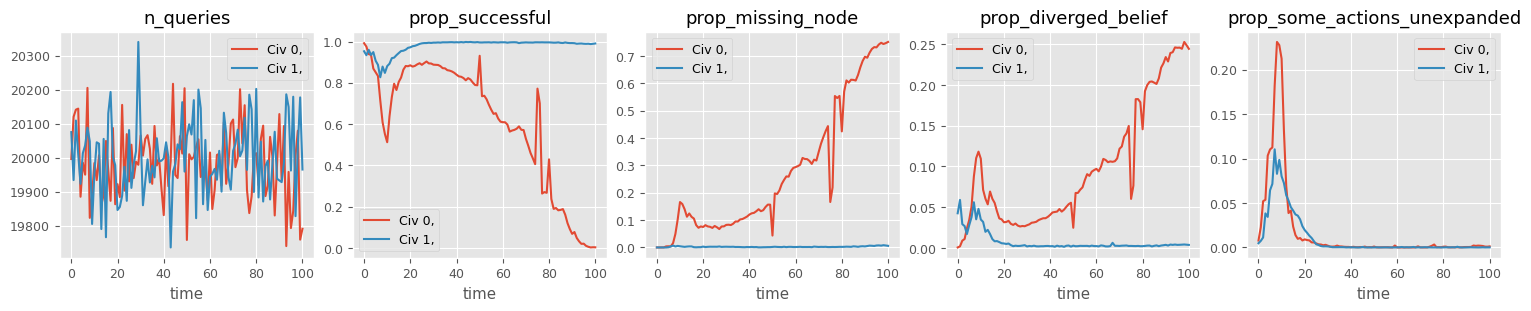

In [8]:
res = results[4]

# let's turn the results into a DataFrame
rows = []

for t, time_step_data in enumerate(res["lower_tree_query_data"]):
    for tree, values in time_step_data.items():
        # if there are no queries, skip
        if values[0] == 0:
            continue

        rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,
    columns=(
        "time",
        "tree",
        "n_queries",
        "prop_successful",
        "prop_missing_node",
        "prop_diverged_belief",
        "prop_some_actions_unexpanded",
    ),
)

# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15, 3))

for i, column in enumerate(query_data.columns[2:]):
    for tree, tree_data in query_data.groupby("tree"):
        axs[i].plot("time", column, data=tree_data, label=tree)

    axs[i].set_title(column)
    axs[i].legend()
    axs[i].set_xlabel("time")

Not all runs finish successfully: the belief in the top-level forest can diverge, which makes continuing impossible. Let's check which runs did not finish and print the parameters of these runs:

In [10]:
n = 0
for r in results:
    if r["run_length"] < 100:
        print(
            f"{r['run_id']}: {r['run_length']}, {r['softargmax_coefficient']:.2f}, {r['exploration_coef']:.2f}, {r['reasoning_level']}"
        )
        n += 1

print(f"Total: {n}")

1105: 6, 0.27, 0.52, 0
347: 2, 0.84, 0.60, 1
45: 2, 0.03, 0.41, 0
1009: 1, 0.79, 0.84, 0
1017: 1, 0.79, 0.84, 0
1117: 3, 0.12, 0.52, 0
451: 48, 0.92, 0.58, 1
1021: 13, 0.43, 0.84, 0
1121: 16, 0.27, 0.81, 0
443: 35, 0.92, 0.68, 1
1133: 1, 0.97, 0.57, 0
797: 1, 0.88, 0.12, 0
1461: 1, 0.89, 0.85, 0
1187: 39, 0.71, 0.82, 1
631: 38, 0.04, 0.89, 1
1277: 1, 0.26, 0.47, 0
1377: 4, 0.35, 0.58, 0
1369: 1, 0.35, 0.58, 0
1445: 11, 0.41, 0.88, 0
1365: 16, 0.58, 0.43, 0
715: 37, 0.29, 1.00, 1
633: 2, 0.04, 0.89, 0
733: 1, 0.35, 0.34, 0
1197: 5, 0.26, 0.11, 0
1189: 2, 0.26, 0.82, 0
1332: 44, 0.45, 0.14, 0
1185: 2, 0.71, 0.82, 0
721: 1, 0.52, 0.34, 0
617: 1, 0.76, 0.51, 0
609: 2, 0.76, 0.49, 0
129: 6, 0.99, 0.42, 0
137: 20, 0.99, 0.85, 0
257: 11, 0.37, 0.70, 0
349: 1, 0.89, 0.60, 0
1107: 5, 0.27, 0.52, 1
345: 2, 0.84, 0.60, 0
1119: 2, 0.12, 0.52, 1
541: 3, 0.24, 0.10, 0
453: 1, 0.31, 0.58, 0
601: 24, 0.76, 0.49, 0
133: 2, 0.47, 0.42, 0
384: 44, 0.61, 0.80, 0
713: 10, 0.29, 1.00, 0
613: 7, 0.86, 0.49, 

Interesting: in most divergence cases the reasoning level is 0. 

Let's visualise the query success rates as averages over all runs over time.

In [11]:
# let's turn the results into a DataFrame
rows = []

# the simulations are level 1 (or 0, but these we ignore)
tree_levels = {"Civ 0,": 1, "Civ 1,": 1}

for run_result in results:
    if run_result["reasoning_level"] == 0:
        continue

    if run_result["action_dist_0"] != "random":
        # we ignore cases where the level 0 policy is not random
        continue

    softargmax_coef = run_result["softargmax_coefficient"]
    exploration_coef = run_result["exploration_coef"]

    for t, time_step_data in enumerate(run_result["lower_tree_query_data"]):
        for tree, values in time_step_data.items():
            # if there are no queries, skip
            if values[0] == 0:
                continue

            level = tree_levels[tree]

            rows.append((t, tree, softargmax_coef, exploration_coef, level, *values))

query_data = pd.DataFrame(
    rows,
    columns=(
        "time",
        "tree",
        "softargmax_coef",
        "exploration_coef",
        "level",
        "n_queries",
        "prop_successful",
        "prop_missing_node",
        "prop_diverged_belief",
        "prop_some_actions_unexpanded",
    ),
)

# add bins for softargmax_coef
softargmax_coef_bins = np.linspace(0.01, 1, 3)
query_data["softargmax_coef_bin"] = pd.cut(
    x=query_data["softargmax_coef"], bins=softargmax_coef_bins, precision=3
)

# add bins of exploration coefficient
exploration_coef_bins = np.linspace(0.1, 1, 3)
query_data["exploration_coef_bin"] = pd.cut(
    x=query_data["exploration_coef"], bins=exploration_coef_bins, precision=3
)

In [12]:
query_data

,time,tree,softargmax_coef,exploration_coef,level,n_queries,prop_successful,prop_missing_node,prop_diverged_belief,prop_some_actions_unexpanded,softargmax_coef_bin,exploration_coef_bin
0,0,"Civ 0,",0.964228,0.320237,1,32715,0.798074,0.025493,0.034204,0.142228,"(0.505, 1.0]","(0.1, 0.55]"
1,0,"Civ 1,",0.964228,0.320237,1,32874,0.800754,0.024579,0.033279,0.141388,"(0.505, 1.0]","(0.1, 0.55]"
2,1,"Civ 0,",0.964228,0.320237,1,33907,0.735010,0.047925,0.051936,0.165128,"(0.505, 1.0]","(0.1, 0.55]"
3,1,"Civ 1,",0.964228,0.320237,1,33909,0.817482,0.016928,0.033177,0.132413,"(0.505, 1.0]","(0.1, 0.55]"
4,2,"Civ 0,",0.964228,0.320237,1,33802,0.729069,0.051032,0.056920,0.162979,"(0.505, 1.0]","(0.1, 0.55]"
...,...,...,...,...,...,...,...,...,...,...,...,...
77185,98,"Civ 1,",0.429023,0.895181,1,24851,0.000000,0.800732,0.199268,0.000000,"(0.01, 0.505]","(0.55, 1.0]"
77186,99,"Civ 0,",0.429023,0.895181,1,25182,0.000000,0.800770,0.199230,0.000000,"(0.01, 0.505]","(0.55, 1.0]"
77187,99,"Civ 1,",0.429023,0.895181,1,24658,0.000000,0.801160,0.198840,0.000000,"(0.01, 0.505]","(0.55, 1.0]"
77188,100,"Civ 0,",0.429023,0.895181,1,24757,0.000000,0.797148,0.202852,0.000000,"(0.01, 0.505]","(0.55, 1.0]"


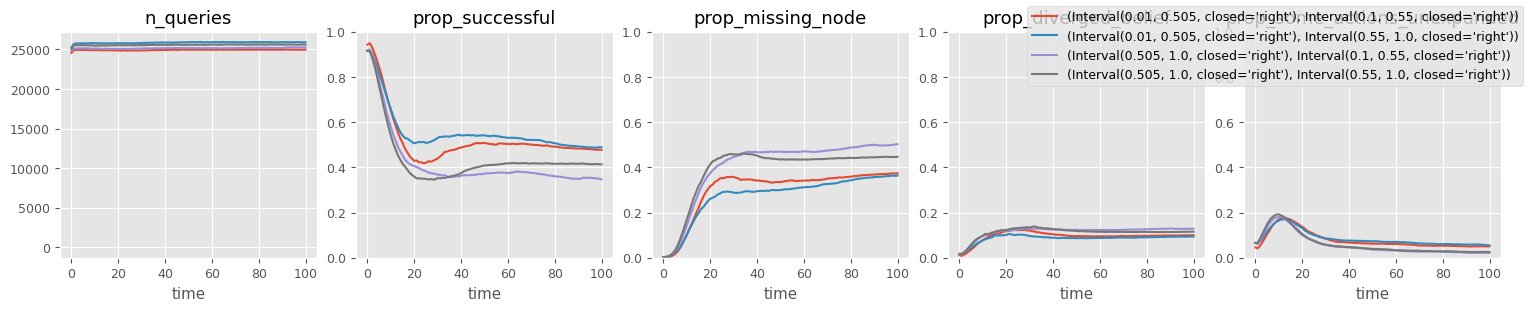

In [13]:
# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15, 3))

metrics = [
    "n_queries",
    "prop_successful",
    "prop_missing_node",
    "prop_diverged_belief",
    "prop_some_actions_unexpanded",
]

for i, metric in enumerate(metrics):
    for group, group_data in query_data.groupby(
        ["softargmax_coef_bin", "exploration_coef_bin"]
    ):
        avg_metric = group_data.groupby("time")[metric].mean()

        axs[i].plot(avg_metric.index, avg_metric, label=group if i == 0 else None)

    axs[i].set_title(metric)
    axs[i].set_xlabel("time")

    if metric != "n_queries":
        axs[i].set_ylim((0, 1))
    else:
        # add point 0 to data limits so scaling is correct
        axs[i].update_datalim([(0, 0)])

fig.legend()
plt.show()

- goal is to have accurate predictions, which necessitates that the exploration coefficient is sufficiently high (but not too high to still focus the samples sufficiently)
- when you have accurate predictions, you can use them quite (but not too) strictly, i.e. have a relatively low softargmax coefficient
- why do some combinations have a lower number of queries? This means that the belief in the simulated forest diverges more often, which causes the simulations not to go as deep on average. Beliefs often diverge because of lack of diversity with regards to the other agents' actions, e.g. predicting an attack but observing none. Since a high softargmax coefficient promotes diversity, intuitively the runs with a very low softargmax coefficient would tend to have more belief divergences.
    - however, the data disagrees. It shows that the runs with a high exploration coefficient tend to go deeper. Within the high exploration coefficient group, the smaller the softargmax coefficient, the more queries.
- softargmax determines how much the lower trees grow, since it determines which nodes in the lower forest are retained

In [14]:
# ugly but works:
pretty_labels = {
    "(Interval(0.01, 0.505, closed='right'), Interval(0.1, 0.55, closed='right'))": r"$c_\mathrm{sft} < 0.5$"
    + "\n"
    + r"$c_\mathrm{explr} < 0.55$",
    "(Interval(0.01, 0.505, closed='right'), Interval(0.55, 1.0, closed='right'))": r"$c_\mathrm{sft} < 0.5$"
    + "\n"
    + r"$c_\mathrm{explr} > 0.55$",
    "(Interval(0.505, 1.0, closed='right'), Interval(0.1, 0.55, closed='right'))": r"$c_\mathrm{sft} > 0.5$"
    + "\n"
    + r"$c_\mathrm{explr} < 0.55$",
    "(Interval(0.505, 1.0, closed='right'), Interval(0.55, 1.0, closed='right'))": r"$c_\mathrm{sft} > 0.5$"
    + "\n"
    + r"$c_\mathrm{explr} > 0.55$",
}

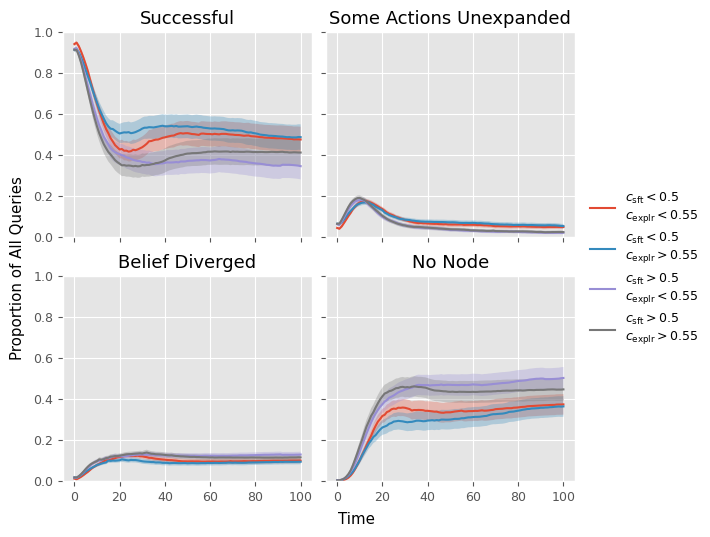

In [16]:
# plot
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    constrained_layout=True,
    figsize=(TWO_COLUMN_FIG_WIDTH, 0.75 * TWO_COLUMN_FIG_WIDTH),
    sharex=True,
    sharey=True,
)

ax_indices = {
    "prop_successful": (0, 0),
    "prop_missing_node": (1, 1),
    "prop_diverged_belief": (1, 0),
    "prop_some_actions_unexpanded": (0, 1),
}

pretty_titles = {
    "prop_successful": "Successful",
    "prop_missing_node": "No Node",
    "prop_diverged_belief": "Belief Diverged",
    "prop_some_actions_unexpanded": "Some Actions Unexpanded",
}

for metric in ax_indices.keys():
    ax = axs[*ax_indices[metric]]

    for group, group_data in query_data.groupby(
        ["softargmax_coef_bin", "exploration_coef_bin"]
    ):
        avg_metric = group_data.groupby("time")[metric].mean()
        avg_metric_error_margin = group_data.groupby("time")[metric].aggregate(
            lambda x: analyse.t_confidence_interval(x)[1]
        )

        ax.plot(avg_metric.index, avg_metric, label=pretty_labels[str(group)])
        ax.fill_between(
            avg_metric.index,
            avg_metric + avg_metric_error_margin,
            avg_metric - avg_metric_error_margin,
            alpha=0.3,
        )

    ax.set_title(pretty_titles[metric])

    if metric != "n_queries":
        ax.set_ylim((0, 1))
    else:
        # add point 0 to data limits so scaling is correct
        ax.update_datalim([(0, 0)])

fig.supxlabel("Time")
fig.supylabel("Proportion of All Queries")

handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(
    unique_labels.values(), unique_labels.keys(), loc="outside right", frameon=False
)  # loc=(0.75, 0.8))

# plt.savefig("paper/lower_tree_queries.pdf")
plt.show()

Let's calculate the average proportion of all actions that are attacks at each reward level:

In [17]:
rows = []

for run_result in results:
    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coefficient"]
    action_dist_0 = run_result["action_dist_0"]
    discount_factor = run_result["discount_factor"]

    run_actions = run_result["actions"]
    prop_no_action = (
        (run_actions["action"] == 0)
        | ((run_actions["action"] == "a") & (run_actions["attack_successful"].isnull()))
    ).mean()
    prop_attack = (
        (run_actions["action"] == "a") & (~run_actions["attack_successful"].isnull())
    ).mean()
    # prop_no_action = (run_actions["action"] == 0).mean()
    # prop_attack = (run_actions["action"] == "a").mean()
    prop_hide = (run_actions["action"] == 1).mean()
    rows.append(
        (
            run_id,
            run_length,
            attack_reward,
            reasoning_level,
            exploration_coef,
            softargmax_coef,
            action_dist_0,
            discount_factor,
            prop_no_action,
            prop_attack,
            prop_hide,
        )
    )

prop_action_data = pd.DataFrame(
    rows,
    columns=(
        "run_id",
        "run_length",
        "attack_reward",
        "reasoning_level",
        "exploration_coef",
        "softargmax_coef",
        "action_dist_0",
        "discount_factor",
        "prop_no_action",
        "prop_attack",
        "prop_hide",
    ),
)

# add bins for attack reward
bins = np.linspace(-0.2, 0.1, 31)
prop_action_data["attack_reward_bin"] = pd.cut(
    x=prop_action_data["attack_reward"], bins=bins, include_lowest=True
)

In [18]:
prop_action_data.groupby("attack_reward_bin").size()

attack_reward_bin
(-0.201, -0.19]      48
(-0.19, -0.18]       48
(-0.18, -0.17]       48
(-0.17, -0.16]       56
(-0.16, -0.15]       48
(-0.15, -0.14]       64
(-0.14, -0.13]       48
(-0.13, -0.12]       48
(-0.12, -0.11]       72
(-0.11, -0.1]        24
(-0.1, -0.09]        56
(-0.09, -0.08]       64
(-0.08, -0.07]       48
(-0.07, -0.06]       40
(-0.06, -0.05]       56
(-0.05, -0.04]       48
(-0.04, -0.03]       56
(-0.03, -0.02]       48
(-0.02, -0.01]       40
(-0.01, 2.78e-17]    48
(2.78e-17, 0.01]     72
(0.01, 0.02]         48
(0.02, 0.03]         48
(0.03, 0.04]         48
(0.04, 0.05]         48
(0.05, 0.06]         48
(0.06, 0.07]         56
(0.07, 0.08]         48
(0.08, 0.09]         64
(0.09, 0.1]          48
dtype: int64

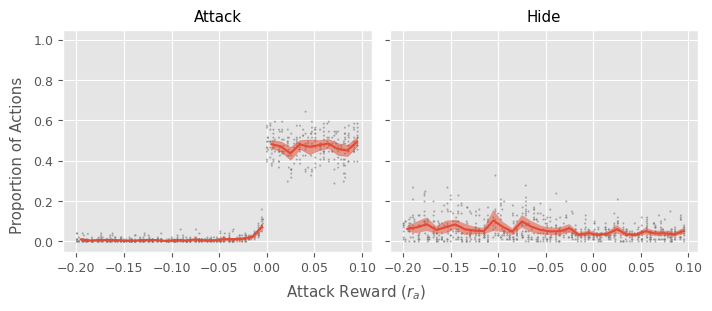

In [20]:
metrics = ("prop_attack", "prop_hide")
fancy_titles = {
    "prop_no_action": "No action",
    "prop_attack": "Attack",
    "prop_hide": "Hide",
}
colors = {0: "gray", 1: "gray"}

prop_action_data_ = prop_action_data[
    (prop_action_data["run_length"] >= 50)
    & (prop_action_data["action_dist_0"] == "random")
]

fig, axs = plt.subplots(
    ncols=len(metrics),
    nrows=1,
    constrained_layout=True,
    figsize=(TWO_COLUMN_FIG_WIDTH, 3),
    sharey=True,
    sharex=True,
)

for i, metric in enumerate(metrics):
    axs[i].scatter(
        x=prop_action_data_["attack_reward"],
        y=prop_action_data_[metric],
        marker="o",
        s=1,
        c=[colors[l] for l in prop_action_data_["reasoning_level"]],
        alpha=0.5,
    )

    prop_action_data_groups = prop_action_data_.groupby("attack_reward_bin")
    avg_metric = prop_action_data_groups.mean(numeric_only=True)[metric]
    avg_metric_error_margin = prop_action_data_groups[metric].aggregate(
        lambda x: analyse.t_confidence_interval(x)[1]
    )
    midpoints = pd.IntervalIndex(avg_metric.index).mid

    # show discontinuity at 0
    if metric == "prop_attack":
        subset = midpoints < 0
        lines = axs[i].plot(midpoints[subset], avg_metric[subset])
        color = lines[0].get_color()
        axs[i].fill_between(
            midpoints[subset],
            avg_metric[subset] - avg_metric_error_margin[subset],
            avg_metric[subset] + avg_metric_error_margin[subset],
            color=color,
            alpha=0.5,
        )

        subset = midpoints > 0
        axs[i].plot(midpoints[subset], avg_metric[subset], color=color)
        axs[i].fill_between(
            midpoints[subset],
            avg_metric[subset] - avg_metric_error_margin[subset],
            avg_metric[subset] + avg_metric_error_margin[subset],
            color=color,
            alpha=0.5,
        )
    else:
        axs[i].plot(midpoints, avg_metric)
        axs[i].fill_between(
            midpoints,
            avg_metric - avg_metric_error_margin,
            avg_metric + avg_metric_error_margin,
            alpha=0.5,
        )

    axs[i].set_title(fancy_titles[metric], fontsize="large")
    axs[i].set_ylim((-0.05, 1.05))

fig.supxlabel(r"Attack Reward ($r_a$)", color=plt.rcParams["xtick.color"])
fig.supylabel("Proportion of Actions", color=plt.rcParams["xtick.color"])

# plt.savefig("paper/experiment3_prop_actions.pdf")
plt.show()

Later, we notice that the discount factor seems to have a sizable effect on the proportion of hiding actions taken. Let's expore this:

discount_factor_bin_mid
0.5125    0.008189
0.5375    0.008502
0.5625    0.008941
0.5875    0.008092
0.6125    0.011901
0.6375    0.011352
0.6625    0.011282
0.6875    0.010330
Name: prop_hide, dtype: float64


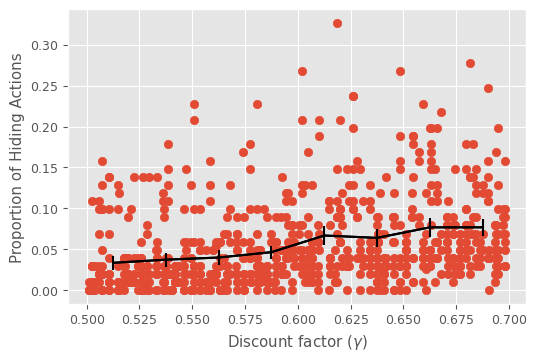

In [21]:
fig, ax = plt.subplots(
    figsize=(0.75 * TWO_COLUMN_FIG_WIDTH, 3.5), constrained_layout=True
)

subset = prop_action_data[
    (prop_action_data["action_dist_0"] == "random")
    & (prop_action_data["reasoning_level"].isin((0, 1)))
].copy()

discount_factor_bins = np.linspace(0.5, 0.7, 9)
bins = pd.IntervalIndex(
    pd.cut(subset["discount_factor"], bins=discount_factor_bins)
).mid
subset["discount_factor_bin_mid"] = bins

ax.scatter(subset["discount_factor"], subset["prop_hide"])

avg_prop_hide = subset.groupby("discount_factor_bin_mid")["prop_hide"].mean()

avg_prop_hide_error_margin = subset.groupby("discount_factor_bin_mid")["prop_hide"].agg(
    lambda x: analyse.t_confidence_interval(x)[1]
)
print(avg_prop_hide_error_margin)

ax.plot(avg_prop_hide.index, avg_prop_hide, color="black")
ax.errorbar(
    x=avg_prop_hide.index,
    y=avg_prop_hide,
    yerr=avg_prop_hide_error_margin,
    color="black",
)

ax.set(ylabel="Proportion of Hiding Actions", xlabel=r"Discount factor ($\gamma$)")

# plt.savefig("paper/appendix_discount_factor.pdf")
plt.show()

Let's then plot the average reward received by agents:

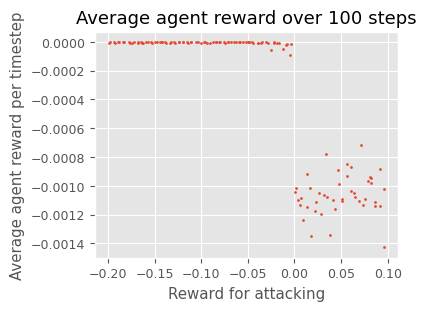

In [25]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    run_rewards = run_result["rewards"]
    avg_run_reward = run_rewards["reward"].mean() / (2 * 101)
    rows.append((attack_reward, avg_run_reward))

avg_reward_data = pd.DataFrame(rows, columns=("attack_reward", "avg_run_reward"))

fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 3))

avg_reward_data_groups = avg_reward_data.groupby("attack_reward")
avg_avg_reward = avg_reward_data_groups.mean()["avg_run_reward"]
avg_avg_reward_error_margin = avg_reward_data_groups.aggregate(
    lambda x: analyse.t_confidence_interval(x)[1]
).iloc[:, 0]

ax.scatter(x=avg_avg_reward.index, y=avg_avg_reward, s=2)
# ax.errorbar(x=avg_avg_reward.index, y=avg_avg_reward, yerr=avg_avg_reward_error_margin, fmt="none", capsize=3)

ax.set_xlabel("Reward for attacking")
ax.set_ylabel("Average agent reward per timestep")
ax.set_title("Average agent reward over 100 steps")

plt.show()

This is a measure of the rationality of the system as a whole. The “rational” scenario for the system is when no one attacks or hides at all.

Next, let's investigate the length of attack streaks. We will only do this when the attack reward is either 0 or 0.1.

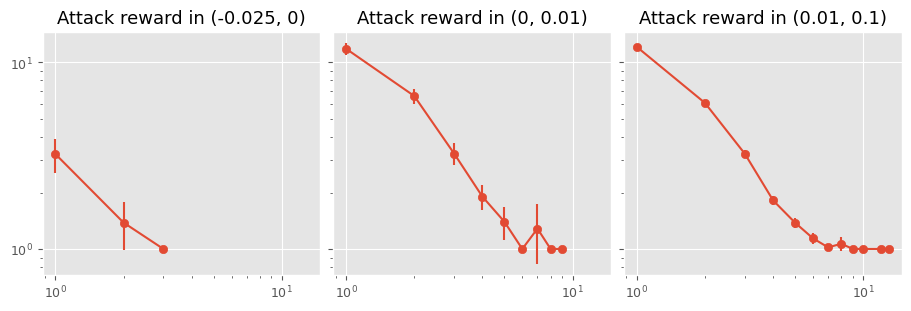

In [26]:
bins = ((-0.025, 0), (0, 0.01), (0.01, 0.1))

fig, axs = plt.subplots(
    nrows=1,
    ncols=len(bins),
    figsize=(3 * len(bins), 3),
    constrained_layout=True,
    sharey=True,
)

rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]

    attack_reward_bin = None
    for i, (bin_l, bin_u) in enumerate(bins):
        if attack_reward >= bin_l and attack_reward < bin_u:
            attack_reward_bin = i
            break

    # if the attack reward is not in an interesting bin, ignore the run
    if attack_reward_bin is None:
        continue

    run_length = run_result["run_length"]
    # exclude runs that were less than 80 time steps (an arbitrary number)
    if run_length < 80:
        continue

    run_action_data = run_result["actions"]

    run_streaks = analyse.count_attack_streaks(run_action_data)

    for streak_length, count in run_streaks.items():
        rows.append((attack_reward_bin, streak_length, count))

attack_streak_data = pd.DataFrame(
    rows, columns=("attack_reward_bin", "streak_length", "streak_count")
)


for i, (attack_reward_bin_i, attack_reward_attack_streak_data) in enumerate(
    attack_streak_data.groupby("attack_reward_bin")
):
    attack_streak_data_grouped = attack_reward_attack_streak_data.groupby(
        "streak_length"
    )
    avg_streak_length_count = attack_streak_data_grouped["streak_count"].mean()
    avg_streak_length_count_error_margin = attack_streak_data_grouped[
        "streak_count"
    ].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    axs[i].scatter(avg_streak_length_count.index, avg_streak_length_count)
    axs[i].errorbar(
        x=avg_streak_length_count.index,
        y=avg_streak_length_count,
        yerr=avg_streak_length_count_error_margin,
    )

    axs[i].update_datalim([(13, 1)])
    axs[i].set_yscale("log")
    axs[i].set_xscale("log")
    axs[i].set_title(f"Attack reward in {bins[attack_reward_bin_i]}")

plt.show()

Let us then start to quantify error in predicting the other agents' actions. First, we will plot the prediction error (norm of the difference vector of action utility estimates) over time for different attack rewards.

In [27]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coefficient"]
    action_dist_0 = run_result["action_dist_0"]
    discount_factor = run_result["discount_factor"]

    if reasoning_level == 0:
        # at level 0 civilisations don't model others rationally
        continue

    action_utility_estimates = run_result["action_qualities"]

    for t, t_data in action_utility_estimates.groupby("time"):
        for estimator, actor in ((0, 1), (1, 0)):
            actor_estimate = t_data[
                (t_data["estimator"] == actor) & (t_data["actor"] == actor)
            ]["qualities"].iloc[0]
            estimator_estimate = t_data[
                (t_data["estimator"] == estimator) & (t_data["actor"] == actor)
            ]["qualities"].iloc[0]
            difference = np.linalg.norm(
                np.array(actor_estimate) - np.array(estimator_estimate)
            )
            rows.append(
                (
                    attack_reward,
                    t,
                    exploration_coef,
                    softargmax_coef,
                    action_dist_0,
                    discount_factor,
                    difference,
                )
            )

action_utility_estimate_data = pd.DataFrame(
    rows,
    columns=(
        "attack_reward",
        "time",
        "exploration_coef",
        "softargmax_coef",
        "action_dist_0",
        "discount_factor",
        "distance",
    ),
)

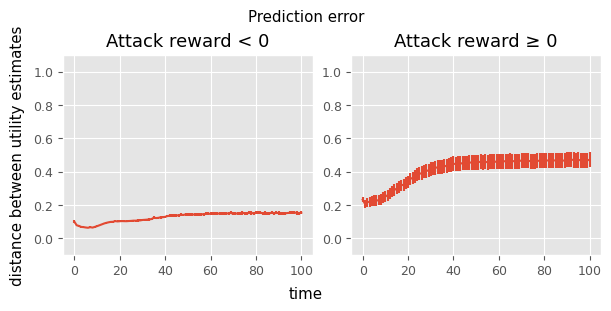

In [28]:
fig, axs = plt.subplots(constrained_layout=True, nrows=1, ncols=2, figsize=(6, 3))

negative_attack_reward = action_utility_estimate_data[
    action_utility_estimate_data["attack_reward"] < 0
]
positive_attack_reward = action_utility_estimate_data[
    action_utility_estimate_data["attack_reward"] >= 0
]

for i, (attack_reward_data) in enumerate(
    (negative_attack_reward, positive_attack_reward)
):
    avg_action_utility_estimate = attack_reward_data.groupby("time")["distance"].mean()
    avg_action_utility_estimate_error_margin = attack_reward_data.groupby("time")[
        "distance"
    ].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    if avg_action_utility_estimate.max() > 0.7:
        print(avg_action_utility_estimate)

    # lines = ax.plot(avg_action_utility_estimate.index, avg_action_utility_estimate, label=attack_reward)
    axs[i].errorbar(
        x=avg_action_utility_estimate.index,
        y=avg_action_utility_estimate,
        yerr=avg_action_utility_estimate_error_margin,
        label=attack_reward,
    )
    axs[i].set_title(f"Attack reward {'< 0' if i == 0 else '≥ 0'}")
    axs[i].set_ylim((-0.1, 1.1))

fig.supxlabel("time")
fig.supylabel("distance between utility estimates")
fig.suptitle("Prediction error")
plt.show()

## Sensitivity Analysis

In [29]:
from SALib.analyze import sobol as analyze

In [30]:
# this is the problem definition used when creating the sample points
problem = {
    "num_vars": 4,
    "names": [
        "attack_reward",
        "discount_factor",
        "softargmax_coef",
        "exploration_coef",
    ],
    "bounds": [[-0.2, 0.1], [0.5, 0.7], [0.01, 1], [0.1, 1]],
}
n_sample_points = 6 * 64

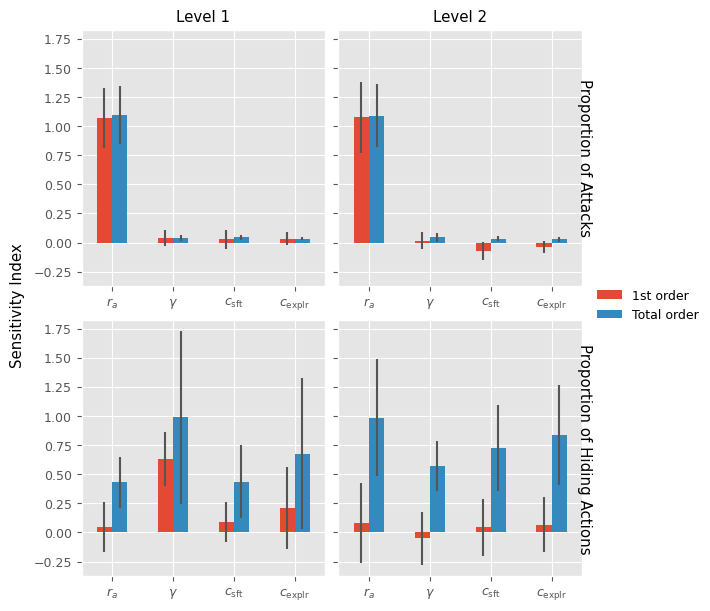

In [31]:
# we need to do a separate analysis for each (reasoning_level, metric) combination
# we are ignoring action_dist_0

fancy_variable_names = {
    "attack_reward": r"$r_a$",
    "discount_factor": r"$\gamma$",
    "softargmax_coef": r"$c_\mathrm{sft}$",
    "exploration_coef": r"$c_\mathrm{explr}$",
}
fancy_output_variable_names = {
    "prop_attack": "Proportion of Attacks",
    "prop_hide": "Proportion of Hiding Actions",
}

target_output_variables = ("prop_attack", "prop_hide")

fig, axs = plt.subplots(
    nrows=len(target_output_variables),
    ncols=2,
    figsize=(TWO_COLUMN_FIG_WIDTH, 3 * len(target_output_variables)),
    constrained_layout=True,
    sharey=True,
)

for row_i, target_variable in enumerate(target_output_variables):
    for col_i, reasoning_level in enumerate((0, 1)):
        ax = axs[row_i, col_i]

        # find correct subset
        data = prop_action_data[
            (prop_action_data["reasoning_level"] == reasoning_level)
            & (prop_action_data["action_dist_0"] == "random")
        ]

        # sort
        data = data.sort_values("run_id")

        # skip cases that are missing all data points
        if len(data) < n_sample_points:
            continue

        # calculate the sensitivity indices
        total, first = analyze.analyze(
            problem=problem,
            Y=data[target_variable].to_numpy(),
            calc_second_order=False,
            seed=42,
        ).to_df()
        sa_data = pd.concat((first, total), axis=1)

        # separate the values and confidence intervals
        conf_cols = sa_data.columns.str.contains("_conf")
        confs = sa_data.loc[:, conf_cols]
        confs.columns = [c.replace("_conf", "") for c in confs.columns]

        values = sa_data.loc[:, ~conf_cols]

        # plot
        values.plot(kind="bar", yerr=confs, rot=0, ax=ax, legend=False)

        if row_i == 0:
            ax.set_title(f"Level {reasoning_level+1}", fontsize="large")
        # if col_i == 0:
        #     ax.set_ylabel(f"{target_variable}", fontsize="large")

        labels = ax.get_xticklabels()
        labels = [fancy_variable_names[var.get_text()] for var in labels]
        ax.set_xticklabels(labels)

# fig.suptitle("Sensitivity of Proportion of Attacks")

fig.text(
    x=0.815,
    y=0.62,
    s=fancy_output_variable_names["prop_attack"],
    rotation=-90,
    fontsize="large",
)
fig.text(
    x=0.815,
    y=0.09,
    s=fancy_output_variable_names["prop_hide"],
    rotation=-90,
    fontsize="large",
)

fig.supylabel("Sensitivity Index")
fig.legend(labels=["1st order", "Total order"], frameon=False, loc="outside right")
# plt.savefig("paper/sensitivity_analysis.pdf")
plt.show()